--- 
Project for the course in Microeconometrics | Summer 2021, M.Sc. Economics, Bonn University | [Mengxi Wang](https://github.com/Mengxi-20)

# Replication of Chen, T., Kung, J. K. S., & Ma, C. (2020) <a class="tocSkip">   
---

This notebook contains my replication of the results from the following paper:

> Chen, T., Kung, J. K. S., & Ma, C. (2020). Long Live Keju! The Persistent Effects of China’s Civil Examination System. The Economic Journal, 130(631), 2030–2064. 

##### Downloading and viewing this notebook:


* The best way to view this notebook is by downloading it and the repository it is located in from [GitHub](https://github.com/OpenSourceEconomics/ose-data-science-course-project-Mengxi-20). Other viewing options like _MyBinder_ or _NBViewer_ may have issues with displaying images or coloring of certain parts (missing images can be viewed in the folder [files](https://github.com/OpenSourceEconomics/ose-data-science-course-project-Mengxi-20) on GitHub).

* The original paper, as well as the data and Stata code provided by the authors can be accessed [here](https://academic.oup.com/ej/article/130/631/2030/5819954).

* Please note that the paper that is studied in this notebook was published in the Economic Journal in 2020. If you follow along this notebook with the 2016 version of the paper, differences in results and labeling occur.

<h1>Table of Contents<span class="tocSkip"></span></h1>

1. [Introduction](#introduction)
2. [Identification](#identification)
3. [Empirical Setup](#setup)
4. [Replication of Chen et al. (2020)](#replication)
    1. [Data & Descriptive Statistics](#data) 
    2. [Keju and Distance to the Printing Ingredients](#instrument)
    3. [Measuring the Impact of Keju on Contemporary Human Capital Outcomes](#reg)
        1. [Baseline OLS](#OLS)
        2. [TSLS Estimates](#TSLS)
5. [Extension](#extention)
    1. [Weak Instrument Test](#weak_ins) 
    2. [The Persistent Effect of Keju Culture on Mainland China’s Current Population with Distinct Levels of Education](#Persistent_effect) 
        1. [Inspiration and Assumption](#inspiration_assumption)
        2. [Data Processing](#data_processing)
        3. [Examination and Results](#reg2)
6. [Conclusion](#conclusion)
7. [References](#references)


In [50]:
%matplotlib inline
!pip install linearmodels
!pip install graphviz
!pip install stargazer
!pip install FixedEffectModel

In [51]:
import sys
import numpy as np
import pandas as pd
import pandas.io.formats.style
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as mp, seaborn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm_api
import warnings
import os

In [52]:
from linearmodels.iv import IV2SLS
from linearmodels import IV2SLS, IVLIML, IVGMM, IVGMMCUE, PanelOLS
from statsmodels.datasets import longley
from linearmodels.panel import compare
from IPython.display import HTML, Image
from stargazer.stargazer import Stargazer
from statsmodels.iolib.summary2 import summary_col
from string import ascii_letters
from FixedEffectModel.api import *

---
# 1. Introduction <a name="introduction"></a>
---

Chen et. al. (2020) examined the effects of China’s civil examination system ([Keju](https://en.wikipedia.org/wiki/Imperial_examination)), a long-lived institution, on human capital outcome todays. Becoming dominant during the Song dynasty (c. 960–1276), Keju is the earliest elite selection system in the world that aims to recruit talents to serve in the bureaucracy. Since Jinshi is the highest honor and qualification in this civil exam, passing the highest level of the exam and receiving the honor of Jinshi means generous pecuniary rewards and a promising future. Over time, the civil examination system formed a distinct group of local elites with deep respect for learning and academic achievements. This cultural characteristic still exists, even a long time after the abolition of the imperial examination system.

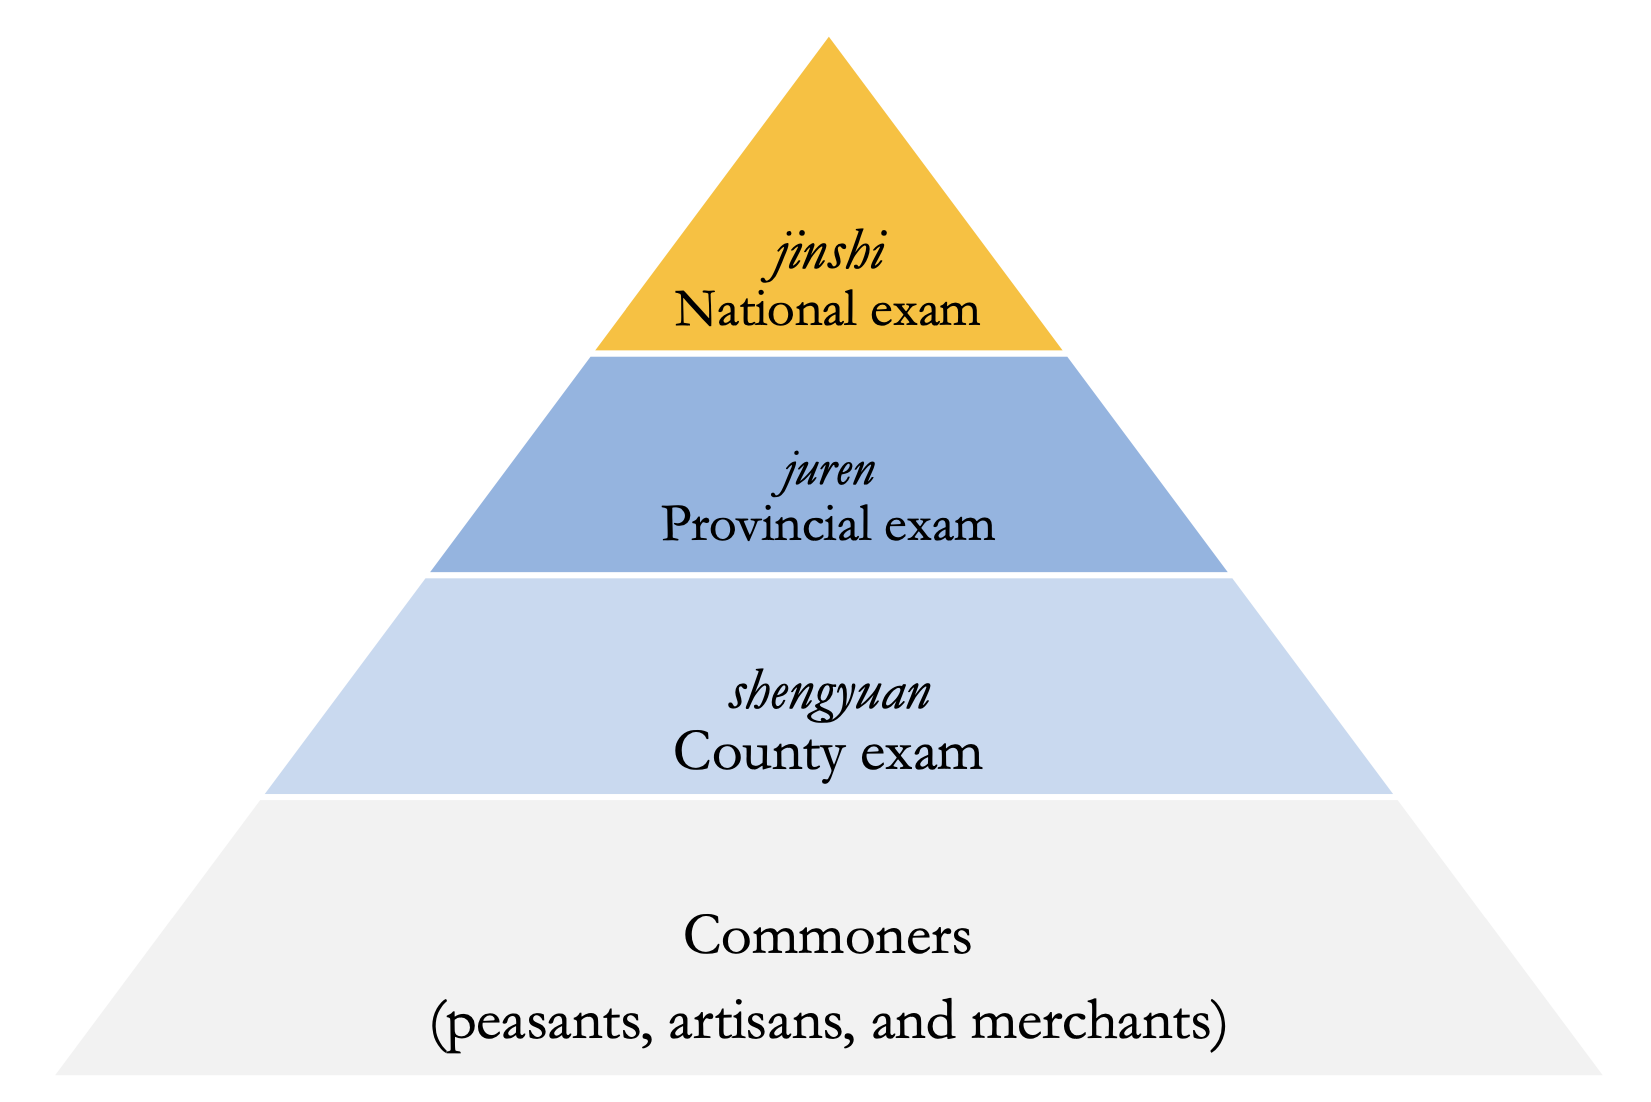

In [53]:
Image("/Users/mengxi/Documents/GitHub/ose-data-science-course-project-Mengxi-20/files/Keju Hierarchy.png",width = 450)

To verify the causal relationship between keju and contemporary human capital outcome, Chen et. al. (2020) introduce an **instrumental variable (IV)** - Distance to the Printing Ingredients (Pine and Bamboo) to tackle the issues of omitted variables bias. The IV is motivated by the idea that to become a winner in the Keju exam, apart from the limited textbooks, the candidates still need a large cluster of reference books, which explain nuances of texts and teach tricks of writing essay. That is why printing ingredients play such an important role in the Keju exam. At the end, Chen et. al. (2020) present the causality and compare OLS and TSLS using different control variables.

This notebook is structured as follows: In the next section the identification strategy is analyzed, then the empirical strategy that the authors use for estimation is briefly discussed. The fourth and the fifth section, as the core of this notebook, show the replication of main results of the paper, present a test for weak instruments and examine the persistent effect of Keju culture on Mainland China’s current population with distinct levels of education. The sixth section offers some concluding remarks.


---
# 2. Identification <a name="identification"></a>
---

In their paper Chen et. al. (2020) aim to verify whether the relationship between Keju and contemporary human capital outcome is causal. However, performance i.e. Jinshi density of various prefectures may be related to many complicated factors. So the estimates of contemporary human capital outcomes to Keju are likely to suffer from omitted variables — variables that are simultaneously associated with both historical jinshi density and years of schooling today. Unobserved factors, like natural or genetic endowments, may be associated with prefectures that had produced more jinshi. Natural or genetic endowments are hard to measure and therefore it is not possible to control them when estimating the impact of Keju to contemporary human capital outcomes. Thus, an omitted variable bias might occur. 

Chen’s approach to avoid bias is now to employ an instrumental variable approach which is based on the accuracy of the causal graph below.

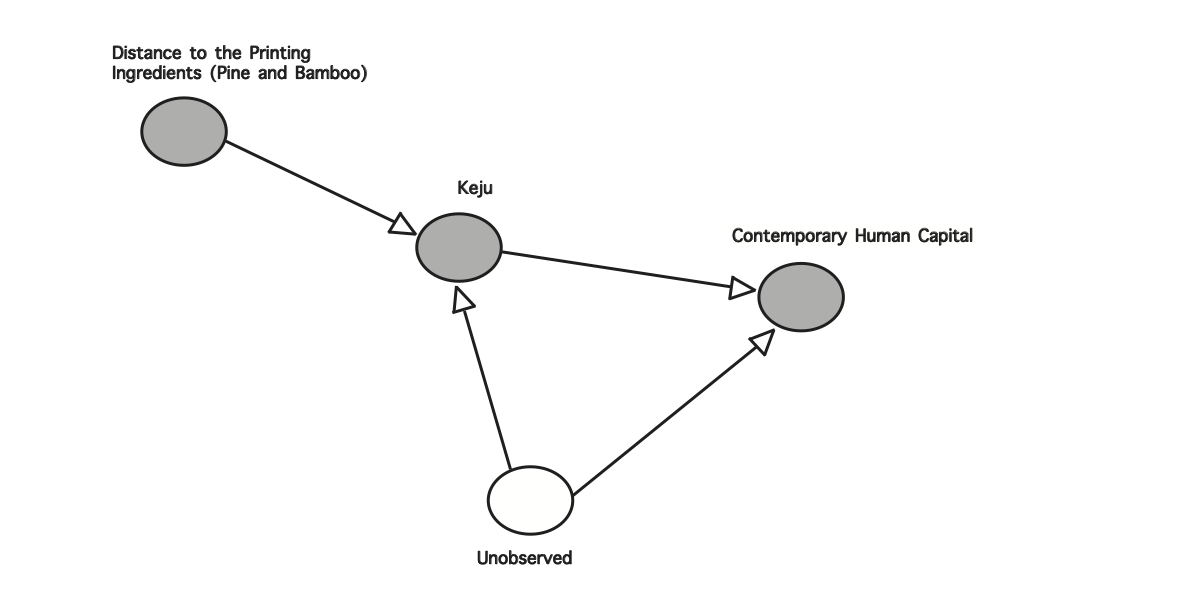

In [54]:
Image("/Users/mengxi/Documents/GitHub/ose-data-science-course-project-Mengxi-20/files/causal graph.png", width = 700)

Chen et. al. (2020) examine the effects of China’s civil examination system using data from the Ming-Qing period (c. 1368–1905). In such a context, the printing technology in China relied mainly on pine and bamboo for producing ink and paper. Typically, the printing centers were located near to the pine and bamboo habitats to reduce the transport costs. Besides, for geographical reasons, the transportation of raw materials i.e. pine and bamboo products was mostly finished via waterways. 

Therefore, an instrumental variable is constructed using a prefecture’s shortest river distance to its nearest sites of pine and bamboo — the two key ingredients required for producing ink and paper in woodblock printing. The following is the logic that why this instrumental variable is feasible and reasonable. 

* To some extent, the performance of various Chinese prefectures in the Keju exam is closely related to the convenience of printing and obtaining books, not only textbooks but also reference books. 

* The main printing centers were located in close to the producing areas of pine and bamboo. 

* The raw materials needed for printing were mainly transported by water via the main river branches. 

Since the geographic distributions of pine and bamboo forests are random, the exogeneity assumption of the instrumental variable holds. 

If instead of a prefecture’s shortest river distance to its nearest sites of pine and bamboo, the shortest distance to printing centers is directly employed as the instrumental variable, there might be problems of exclusion restriction, because the locations of printing centers were not exogenously determined. For example, they were more likely to be located in economically prosperous and densely populated areas. 


---
# 3. Empirical Setup <a name="setup"></a>
---

The authors examined the impact of keju on contemporary human capital outcomes. For the regression analysis Chen et. al. (2020) employ the following model to do the estimation:

\begin{equation}
y_{i} = \beta keju_{i} + \gamma_{1} X^{c}_{i} + \gamma_{2} X^{h}_{i} + \alpha_{p} + \epsilon_{i},
\end{equation}


* $i$ indexes a prefecture,
* $y_{i}$ stands for the contemporary human capital measure constructed from the 2010 population census,
* $\alpha_{p}$ denotes province fixed effects,
* $\epsilon_{i}$ is the error term,
* $keju_{i}$ is a measure of the degree of success in civil exams of prefecture i in the Ming and Qing dynasties, specifically measured by the total number of candidates who obtained the jinshi degree in the keju exam in that prefecture during the entire Ming-Qing period (c. 1371–1905),
* $X^{c}_{i}$ denotes a vector of baseline control variables, which are likely to impact upon the years of schooling today, including night-time lights and key features of geography,
* $X^{h}_{i}$ denotes a vector of historical variables, which are likely correlated with jinshi density while also bearing upon contemporary human capital outcomes, including historical economic prosperity and regional migration.

Key variables in the data sets:


In [55]:
file_path = 'files/Abb_1.txt'
with open(file_path) as file_abb_1:
    abb1 = file_abb_1.read()
print(abb1)

lneduyear       Average years of schooling (logged)
lnjinshipop     Jinshi density (logged)
lnnspop         Share of population with no education (×100, logged)
lnmppop         Share of population with elementary and secondary school education (×100, logged)
lnhighpop       Share of population with high school education (×100, logged)
lnunipop        Share of population with university and above (×100, logged)
lnnightlight    Night-time lights in 2010 (logged)
lncoastdist     Distance to coast (1,000 km, logged)
tri             Terrain ruggedness
suitability     Agricultural suitability
lnpopdensity    Population density (logged)
urbanrates      Urbanisation rates
provid          Province fixed effects


---
# 4. Replication of Ting Chen, James Kai-sing Kung and Chicheng Ma (2020)<a name="replication"></a>
---

## 4.1. Data & Descriptive Statistics <a name="data"></a>


To obtain the data of key explanatory variable — $keju_{i}$, Chen et. al. (2020) filtered data from Official Directory of Ming-Qing Civil Exam Graduates. After sorting out the jinshi degrees obtained in the 242 civil exams that took place between 1371 and 1904, the authors normalized the number of jinshi by the prefecture population (in units of 10,000).

Furthermore, in order to reduce skewness, they raised the number of jinshi density to the natural log. At the end, the authors add 1 to the number of jinshi, i.e., ln(1 + jinshi/population), in case of losing observations with a value of zero. The processed data named jinshi density are used to measure the historical success in China’s civil exam (Keju).

Besides, the data of dependent variable — $y_{i}$, come from the 2010 Chinese Family Panel Survey (CFPS). “Average years of schooling" in the census was selected and raised to the natural log to measure the contemporary human capital. 

As for control variables $X^{c}_{i}$ and $X^{h}_{i}$ , they are constructed as follows. 

The vector of baseline control variables — $X^{c}_{i}$:

| Baseline controls | Construction | Comments | 
| :--- | :--- | :--- |
| Night-time lights | the average satellite light density at night time in 2010 at the prefectural level | Measuring the contemporary economic prosperity | 
| geography 1: distance to coast | the distance between a prefecture’s centroid to the closest point on the coast | prefectures located on the coast were likely early beneficiaries of Western technology, knowledge and trade | 
| geography 2: terrain ruggedness | the difference in elevation between adjacent cell grids using data provided by the United States Geographic Service (USGS) | terrain ruggedness can have a profoundly lasting effect on long-term economic development either through its direct impact or through its interaction with key historical events | 


The vector of historical variables — $X^{h}_{i}$:

| Historical controls | Construction | Comments | 
| :--- | :--- | :--- |
| historical economic prosperity 1: population density | the average population density between 1393 and 1910 | / | 
| historical economic prosperity 2: urbanisation | the average share of the urban population between 1393 and 1920 | / | 
| historical economic prosperity 3: agricultural suitability | yields of crops suitable for cultivation after 1500 based on the Caloric Suitability Indices (Galor and Ozak, 2016) | China was still predominantly an agricultural economy in the Ming-Qing period. | 
| Regional migration | the 1,370 jinshi (2.65%) whose birthplace was different from the place of examination are excluded from the analysis | migration may affect development if prefectures with a proven track record in civil exams attracted candidates to migrate to these places. | 



The following tables show the descriptive statistics. Table_1 and Table_2 provide a basic feel for the data in front of us. Table_3 provides an overview of data for the main variables, which will be used later in the empirical analysis. 

In [56]:
data = pd.read_csv('data/census20_final.csv')
data = pd.DataFrame(data)

In [57]:
# Table 1
Table_1 = data.describe()
Table_1

,provid,prefid,year,lneduyear,lnjinshipop,lnjinshipopm,lnnspop,lnmppop,lnhighpop,lnunipop,...,noise491,noise492,noise493,noise494,noise495,noise496,noise497,noise498,noise499,noise500
count,274.0000,274.0000,274.0000,274.0000,274.0000,274.0000,274.0000,274.0000,274.0000,274.0000,...,274.0000,274.0000,274.0000,274.0000,274.0000,274.0000,274.0000,274.0000,274.0000,274.0000
mean,40.5730,"406,766.0584","2,010.0000",2.1605,0.9175,0.6782,1.6391,4.2677,2.5939,0.8781,...,0.2630,0.2299,-0.2318,-0.1817,-0.3504,0.1149,0.1645,0.2097,-0.2874,-0.2735
std,13.2937,"133,168.4856",0.0000,0.1181,0.7012,0.3365,0.5875,0.1067,0.3157,0.6533,...,1.0722,1.1595,1.0566,1.1133,1.0700,0.9479,1.0838,1.1055,1.1172,0.9957
min,11.0000,"110,000.0000","2,010.0000",1.7263,0.0000,0.0000,-0.3013,3.7637,1.6459,-0.9542,...,-2.1951,-2.7219,-2.6843,-3.5028,-3.5412,-2.4880,-3.8188,-3.0189,-3.5080,-2.5672
25%,34.0000,"341,025.0000","2,010.0000",2.1020,0.5242,0.4593,1.2693,4.2315,2.4214,0.4512,...,-0.4471,-0.5500,-0.9240,-0.9192,-1.0530,-0.4229,-0.6017,-0.4821,-1.1197,-0.9703
50%,42.0000,"420,750.0000","2,010.0000",2.1696,0.7886,0.6664,1.6040,4.2911,2.6212,0.7805,...,0.2152,0.2159,-0.2134,-0.1083,-0.4059,0.1104,0.2521,0.3125,-0.2788,-0.4692
75%,51.0000,"510,975.0000","2,010.0000",2.2308,1.0542,0.9026,2.0073,4.3363,2.8190,1.1287,...,0.9702,1.0214,0.4542,0.4962,0.3686,0.6506,1.0030,0.9337,0.3847,0.4150
max,64.0000,"640,400.0000","2,010.0000",2.4604,3.9586,2.6693,3.3877,4.4361,3.2574,3.0056,...,3.5865,3.3665,3.2088,2.2670,2.7884,2.8806,2.6137,3.3386,2.6631,2.7870


In [58]:
# Table 2
Table_2 = data.head()
Table_2

,provid,prefid,year,lneduyear,lnjinshipop,lnjinshipopm,lnnspop,lnmppop,lnhighpop,lnunipop,...,noise491,noise492,noise493,noise494,noise495,noise496,noise497,noise498,noise499,noise500
0,11,110000,2010,2.4604,3.5248,0.9486,0.6594,3.7637,3.0965,3.0056,...,0.7351,-0.2041,-0.0514,-2.3067,0.1065,0.6420,0.2642,-0.6155,-1.7474,-0.9722
1,12,120000,2010,2.3399,3.7154,1.0898,0.9246,4.0544,3.0714,2.2475,...,0.4868,0.2090,-0.0861,-1.1690,0.1646,0.5628,-0.8489,-1.2235,-0.6774,-0.3513
2,13,130100,2010,2.2915,0.7400,0.6455,1.0677,4.1745,2.9125,1.6867,...,0.5225,0.1080,-1.7728,0.1416,1.3909,1.0535,-0.6438,0.1106,0.0275,-0.7560
3,13,130200,2010,2.2343,0.6294,0.5687,0.9862,4.2778,2.7622,1.2640,...,0.7318,0.2132,-0.4543,-2.2339,0.4930,0.5741,1.3473,0.9585,-1.4011,-0.7569
4,13,130300,2010,2.2649,0.7683,0.6954,0.7792,4.2417,2.7693,1.7031,...,1.6653,-0.1812,-0.2342,-2.3458,0.2147,0.4110,0.7786,0.3804,-1.3388,0.5225


In [59]:
def table_sum_stats(data):
    
    variables = data[
        [
            "lneduyear",
            "lnjinshipop",
            "lnnightlight",
            "lncoastdist",
            "tri",
            "suitability",
            "lnpopdensity",
            "urbanrates",
            "lnprint",
            "pcenter",
            "bprvdist",
            "rvrdist",
        ]
    ]

    table = pd.DataFrame()
    table["Observation"] = variables.count()
    table["Mean"] = variables.mean()
    table["Standard Deviation"] = variables.std()
    table["min"] = variables.min()
    table["max"] = variables.max()
    table = table.astype(float).round(3)
    table["Description"] = [
            "Average years of schooling (logged)",
            "Jinshi density (logged)",
            "Night-time lights in 2010 (logged)",
            "Distance to coast (1,000 km, logged)",
            "Terrain ruggedness",
            "Agricultural suitability",
            "Population density (logged)",
            "Urbanisation rates",
            "Printed books (logged)",
            "Printing centre",
            "Shortest river distance to pine/bamboo (km, logged)",
            "Shortest distance to major navigable rivers (km, logged)",
    ]
    

    return table

In [60]:
# Table 3
table_3 = table_sum_stats(data)
table_3

,Observation,Mean,Standard Deviation,min,max,Description
lneduyear,274.0000,2.1600,0.1180,1.7260,2.4600,Average years of schooling (logged)
lnjinshipop,274.0000,0.9170,0.7010,0.0000,3.9590,Jinshi density (logged)
lnnightlight,274.0000,0.7220,1.2460,-4.0720,3.4820,Night-time lights in 2010 (logged)
lncoastdist,274.0000,12.6080,1.1750,9.7310,14.6980,"Distance to coast (1,000 km, logged)"
tri,274.0000,0.2070,0.1750,0.0050,0.8210,Terrain ruggedness
suitability,274.0000,3.0080,0.7160,0.5500,4.8380,Agricultural suitability
lnpopdensity,274.0000,2.1880,0.9920,-1.2970,4.1530,Population density (logged)
urbanrates,274.0000,0.0510,0.0350,0.0000,0.3070,Urbanisation rates
lnprint,274.0000,2.0240,1.6210,0.0000,6.9870,Printed books (logged)
pcenter,274.0000,0.0690,0.2550,0.0000,1.0000,Printing centre


What the dependent variable 'logged average years of schooling' looks like can be found as follows.

In [61]:
def plot_distribution(data, variable):
    
    plot=plt.figure(figsize=(4,4))
    plot=plt.xlim(1,2.5)
    plot=plt.xlabel(variable)
    plot=plt.ylabel('Count')
    plot=sns.histplot(data[variable])
    
    return plot

2.1604706138686143

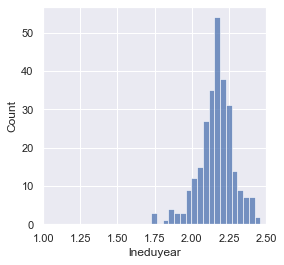

In [62]:
plot_distribution(data, "lneduyear")
data["lneduyear"].mean()

## 4.2. Keju and Distance to the Printing Ingredients <a name="instrument"></a>


As mentioned before, an instrumental variable approach is employed. In order to convincingly pursue the identification strategy outlined above, it is necessary to establish an effect of distance to printing ingredients on jinshi density and to argue that the distance is exogenous to any unobserved factor affecting both jinshi density and contemporary human capital. 

Chen et. al. (2020) constructed the IV using historical GIS data on the major inland rivers from Harvard CHGIS. They computed a prefecture’s shortest river distances to its nearest bamboo and pine forests and then took the average of the two distances as the instrumental variable. The IV data is directly given and named bprdist.

Now, the three conditions for a valid instrument are discussed. The first requirement for IV to be valid holds, as it is clearly observable that distance to printing ingredients has an effect on jinshi density. Examination can be found in Table 4. Below is the diagonal correlation matrix of independent variable, instrumental variable and other relevent variables.

In [63]:
file_path = 'files/Abb_2.txt'
with open(file_path) as file_abb_2:
    abb2 = file_abb_2.read()
print(abb2)

lnprint         Printed books (logged)
pcenter         Printing centre
bprvdist        Shortest river distance to pine/bamboo (km, logged)
rvrdist         Shortest distance to major navigable rivers (km, logged)


<AxesSubplot:>

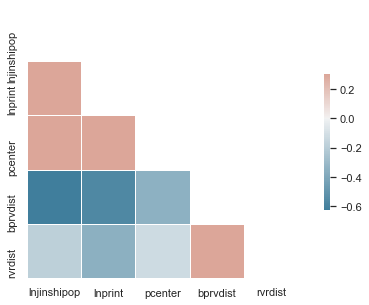

In [64]:
sns.set_theme(style="white")
df = data[
        [
            "lnjinshipop",
            "lnprint",
            "pcenter",
            "bprvdist",
            "rvrdist",
        ]
    ]
df = pd.DataFrame(df)

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(9, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

As for the second requirement, Chen argues that the geographic distribution of pine and bamboo forests is random in nature and hence not correlated with any other unobserved variables (exogenous). The exogeneity assumption of the instrumental variable also holds. 

The importance of pine and bamboo for printing and accordingly a prefecture’s success in the civil exam is examed as follows in Table 4. In column(1) and column(2), by regressing jinshi density on the number of printed books, it is found that they are highly significant. In column(3) and column(4), river distance to the pine and bamboo - the main printing ingredients is significantly correlated with the existence of main printing center in a prefecture. In column(5) and column(6), river distance to printing ingredients is significantly correlated with the number of printed books. In column(7) and column(8), the IV - river distance to pine/bamboo is negatively and significantly correlated with jinshi density. In summary, these results confirm the assumed importance of pine and bamboo in determining the availability of reference books and a prefecture's success in the Keju exams, which is measured by Jinshi density. 

In [65]:
# Table 4 
# final version
provid = pd.Categorical(data.provid)

data['provid'] = provid
data = data.set_index(['provid','year'])

exog_vars = ['lnprint']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lnjinshipop,exog,entity_effects=True)
res_fe_1 = mod.fit()


exog_vars = ['lnprint','lnnightlight','lncoastdist','tri']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lnjinshipop,exog,entity_effects=True)
res_fe_2 = mod.fit(cov_type = 'clustered',cluster_effects=True)


exog_vars = ['bprvdist']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.pcenter,exog,entity_effects=True)
res_fe_3 = mod.fit(cov_type = 'clustered',cluster_effects=True)

exog_vars = ['bprvdist','lnnightlight','lncoastdist','tri']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.pcenter,exog,entity_effects=True)
res_fe_4 = mod.fit(cov_type = 'clustered',cluster_effects=True)

exog_vars = ['bprvdist']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lnprint,exog,entity_effects=True)
res_fe_5 = mod.fit(cov_type = 'clustered',cluster_effects=True)

exog_vars = ['bprvdist','lnnightlight','lncoastdist','tri']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lnprint,exog,entity_effects=True)
res_fe_6 = mod.fit(cov_type = 'clustered',cluster_effects=True)

exog_vars = ['bprvdist']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lnjinshipop,exog,entity_effects=True)
res_fe_7 = mod.fit(cov_type = 'clustered',cluster_effects=True)

exog_vars = ['bprvdist','lnnightlight','lncoastdist','tri']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lnjinshipop,exog,entity_effects=True)
res_fe_8 = mod.fit(cov_type = 'clustered',cluster_effects=True)

print(compare({"(1)jinshi density_log": res_fe_1, "(2)jinshi density_log": res_fe_2, "(3)printing center": res_fe_3, "(4)printing center": res_fe_4}, stars = True, precision = "std_errors"))


print(compare({"(5)printed books_log": res_fe_5, "(6)printed books_log": res_fe_6, "(7)jinshi density_log": res_fe_7, "(8)jinshi density_log": res_fe_8}, stars = True, precision = "std_errors"))


                                             Model Comparison                                            
                        (1)jinshi density_log (2)jinshi density_log (3)printing center (4)printing center
---------------------------------------------------------------------------------------------------------
Dep. Variable                     lnjinshipop           lnjinshipop            pcenter            pcenter
Estimator                            PanelOLS              PanelOLS           PanelOLS           PanelOLS
No. Observations                          274                   274                274                274
Cov. Est.                          Unadjusted             Clustered          Clustered          Clustered
R-squared                              0.1322                0.2876             0.0662             0.0795
R-Squared (Within)                     0.0000                0.0000             0.0000             0.0000
R-Squared (Between)                    0.1189 

The third condition that IV needs to satisfy is exclusion restriction, in other words, the IV only affects the outcome Y through affecting the endogenous regressor X. For exclusion restrictions, little evidence shows that pine and bamboo were intentionally planted for the purpose of commercial printing (Elvin, 2004). Even the most successful wood merchants in Huizhou prefecture of Anhui Province preferred to lumber trees from primordial forests rather than planting on their own (Li, 2000). The locations of pine and bamboo forests are therefore uncorrelated with other omitted variables — most notably economic prosperity (including population density and urbanisation rate of a prefecture), which may be correlated with years of schooling today. 

Last but not least, Chen et. al. (2020) is confident that the IV does not have a direct effect on the contemporary development of the publishing industry and possibly economic prosperity as in the case of Europe, because the traditional Chinese woodblock printing was gradually replaced by the new printing technology in the late 20th century, which means that pine and bamboo as raw materials of printing technology stepped off the history stage. So, river distance to printing ingredients only affects comtemporary human capital through affecting jinshi density.

## 4.3. Measuring the Impact of Keju on Contemporary Human Capital Outcomes <a name="reg"></a>

### 4.3.1. Baseline OLS estimates <a name="OLS"></a>


By plotting correlation between jinshi density (number of jinshi, normalised by their population) and average years of schooling in 2010 in the following figure, it is obvious that there is a strong positive relationship between logged jinshi density and logged average years of schooling, i.e. between a prefecture’s success in the civil exam and contemporary human capital outcomes. So, it is necessary to continue to dig into their relationship. 


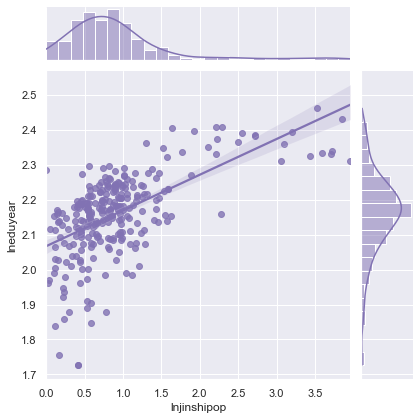

In [66]:
sns.set(style="darkgrid")
g = sns.jointplot("lnjinshipop", "lneduyear", 
                   data=data, kind="reg",
                   color="m", height=6)

We begin by using the number of jinshi normalised by a prefecture’s population (jinshi density) as our key independent variable and regressing average schooling years on the jinshi density to check the the baseline ordinary least squares (OLS) results. Table 5 shows the OLS results without province fixed effect to provide a benchmark. To make the estimation more accurate, we then add province fixed effect on years of schooling into the model - results can be found in Table 6.

In Table 6, column(1) shows the result which is only controlled for province fixed effect and can be regarded as a benchmark. On the basis of column (2), the baseline controls are added into column (2), and the historical controls are further added into column(3). 

In both column(1) and column(2), the acquirement of jinshi honor has a highly significant (at the 1% level) and positive effect on years of schooling. In column(3), the result suggests that for every 10,000 people, a doubling of jinshi density is associated with an increase in years of schooling in 2010 of 6.9%. This is not a small number regarding the huge geographic variations in jinshi density across historical China. In other words, given that the mean of schooling year today is 8.712, a doubling of jinshi density leads to an increase of average schooling years by 0.6 in 2010. This result is robust to the inclusion of a rich gamut of covariates including a prefecture’s economic prosperity both in the Ming-Qing period (population density, urbanisation rate and agricultural suitability) and today (using night-time lights in 2010 as proxy), and not the least geography (terrain ruggedness and distance to coast), all with province fixed effects.

In [67]:
# Table 5

data = pd.read_csv('data/census20_final.csv')
data = pd.DataFrame(data)

result1 = smf.ols('lneduyear ~ lnjinshipop', data = data).fit()
result2 = smf.ols('lneduyear ~ lnjinshipop + lnnightlight + lncoastdist + tri', data = data).fit()
result3 = smf.ols('lneduyear ~ lnjinshipop + lnnightlight + lncoastdist + tri + suitability + lnpopdensity + urbanrates', data = data).fit()

sum = summary_col([result1, result2, result3], stars = True)
print(sum)



               lneduyear I lneduyear II lneduyear III
-----------------------------------------------------
Intercept      2.0667***   1.9978***    2.0257***    
               (0.0094)    (0.0675)     (0.0649)     
R-squared      0.3682      0.5999       0.6678       
R-squared Adj. 0.3659      0.5939       0.6591       
lncoastdist                0.0087       0.0136***    
                           (0.0053)     (0.0050)     
lnjinshipop    0.1022***   0.0677***    0.0711***    
               (0.0081)    (0.0072)     (0.0068)     
lnnightlight               0.0363***    0.0506***    
                           (0.0056)     (0.0057)     
lnpopdensity                            -0.0518***   
                                        (0.0082)     
suitability                             0.0050       
                                        (0.0069)     
tri                        -0.1696***   -0.2963***   
                           (0.0361)     (0.0407)     
urbanrates                 

In [68]:
# Table 6

data = pd.read_csv('data/census20_final.csv')
data = pd.DataFrame(data)

provid = pd.Categorical(data.provid)

data['provid'] = provid
data = data.set_index(['provid','year'])

exog_vars = ['lnjinshipop']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lneduyear,exog,entity_effects=True)
res_1 = mod.fit()

exog_vars = ['lnjinshipop','lnnightlight','lncoastdist','tri']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lneduyear,exog,entity_effects=True)
res_2 = mod.fit()

exog_vars = ['lnjinshipop','lnnightlight','lncoastdist','tri','suitability','lnpopdensity','urbanrates']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lneduyear,exog,entity_effects=True)
res_3 = mod.fit(cov_type = 'clustered',cluster_effects=True)

print(compare({"(1)": res_1, "(2)": res_2, "(3)": res_3}, stars = True, precision = "std_errors"))



                          Model Comparison                          
                                   (1)            (2)            (3)
--------------------------------------------------------------------
Dep. Variable                lneduyear      lneduyear      lneduyear
Estimator                     PanelOLS       PanelOLS       PanelOLS
No. Observations                   274            274            274
Cov. Est.                   Unadjusted     Unadjusted      Clustered
R-squared                       0.4041         0.5584         0.5937
R-Squared (Within)              0.0000         0.0000         0.0000
R-Squared (Between)             0.4725         0.6875         0.7468
R-Squared (Overall)             0.3644         0.5259         0.5960
F-statistic                     166.16         76.498         49.896
P-value (F-stat)                0.0000         0.0000         0.0000
=====================     ============   ============   ============
const                        2.076

### 4.3.2. TSLS Estimates <a name="TSLS"></a>

In the following tables, 2SLS results are reported. 

The results of Table 7 and Table 8 are calculated with the **IV2SLS** function from linearmodels package. Table 7 presents the result of second stage. It is noticed that the parameter of lnjinshipop is 0.0957 and the standard error is 0.0132, which indicate a 1% significance level. So, using the average of the two shortest river distances to pine and bamboo as instrument, it is found that jinshi density significantly and positively explains years of schooling. 

In [69]:
# Table 7
# 2.stage result

data = pd.read_csv('data/census20_final.csv')
data = pd.DataFrame(data)
mod = 'lneduyear ~ 1 + lnnightlight + lncoastdist + tri + suitability + lnpopdensity + urbanrates + [lnjinshipop ~ bprvdist]'
reg = IV2SLS.from_formula(mod, data).fit(cov_type = 'robust')
print (reg)

## 重要的是lnjinshipop前面的系数0.0957，std.err.是0.0132，在1%的水平上显著，论文结果是0.085

                          IV-2SLS Estimation Summary                          
Dep. Variable:              lneduyear   R-squared:                      0.6516
Estimator:                    IV-2SLS   Adj. R-squared:                 0.6424
No. Observations:                 274   F-statistic:                    395.59
Date:                Fri, Jul 23 2021   P-value (F-stat)                0.0000
Time:                        13:33:12   Distribution:                  chi2(7)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
Intercept        2.0245     0.0612     33.066     0.0000      1.9045      2.1446
lnnightlight     0.0461     0.0073     6.336

Table 8 presents the result of first stage. Partial R-squared is 0.3070, which is near to zero and means that the variable values of lnjinshipop are away from the instrument. So the instrument bprvdist can well explain the endogenous variable lnjinshipop. 

In [70]:
# Table 8
# 1.stage result
print(reg.first_stage)

## 重要的是bprvdist前面的系数-0.0723，论文结果是−0.085

    First Stage Estimation Results    
                           lnjinshipop
--------------------------------------
R-squared                       0.4731
Partial R-squared               0.3070
Shea's R-squared                0.3070
Partial F-statistic             65.654
P-value (Partial F-stat)     5.551e-16
Partial F-stat Distn           chi2(1)
========================== ===========
Intercept                       1.4737
                              (3.4804)
lnnightlight                    0.1120
                              (2.8473)
lncoastdist                     0.0028
                              (0.0914)
tri                             1.1996
                              (4.0962)
suitability                    -0.1942
                             (-4.4868)
lnpopdensity                    0.1194
                              (2.4428)
urbanrates                      2.4051
                              (2.0478)
bprvdist                       -0.0723
                         

Though the above mentioned codes are replicating a very close result to that in Chen's paper and can lead to a conclusion with same significance level, there are still small differences in 2SLS results. The cause of the small differences is that the above model using IV2SLS function from linearmodels package doesn't consider the province fixed effect.

To introduce the province fixed effect into the model and to deal with the panel data, another function from the **FixedEffectModel** package is applied, which can be found in Table 10. 

**About the package [FixedEffectModel](https://pypi.org/project/FixedEffectModel/)**: it is a Python package for linear model with high dimensional fixed effects. In Chen et al. (2020)’s paper, there are only one fixed effect estimator and one instrument, but the functions from FixedEffectModel still work very well. Since it is a very specific package and was only updated last month, the codes related to this package is not able to run on GitHub Actions CI. Therefore, I marked # before every line of related codes for **Table 10**, **Table 11** and **Table 12**, and then loaded the results in form of image to make them readable.

Table 9 shows how the panel data looks. 'provid' as the province fixed effect means different provinces in China. For example, '11' stands for the capital of China - Beijing, that's why people in this province have longer average schooling years than that of other provinces.

In [71]:
# Table 9

data = pd.read_csv('data/census20_final.csv')
data = pd.DataFrame(data)

provid = pd.Categorical(data.provid)

data['provid'] = provid
data = data.set_index(['provid','year'])

data

prefid  lneduyear  lnjinshipop  lnjinshipopm  lnnspop  lnmppop  \
provid year                                                                   
11     2010  110000     2.4604       3.5248        0.9486   0.6594   3.7637   
12     2010  120000     2.3399       3.7154        1.0898   0.9246   4.0544   
13     2010  130100     2.2915       0.7400        0.6455   1.0677   4.1745   
       2010  130200     2.2343       0.6294        0.5687   0.9862   4.2778   
       2010  130300     2.2649       0.7683        0.6954   0.7792   4.2417   
...             ...        ...          ...           ...      ...      ...   
63     2010  632300     1.7263       0.4195        0.3885   3.3321   4.0900   
       2010  632500     1.8390       0.1156        0.1111   3.0618   4.1905   
64     2010  640200     2.2322       0.7865        0.7705   1.3358   4.2558   
       2010  640300     2.1078       0.4531        0.4233   1.9546   4.3348   
       2010  640400     1.9838       1.1106        0.9743   2.6172   4.2649   

             lnhighpop  lnunipop  lnnightlight  lncoastdist  ...  noise491  \
provid year                                                  ...             
11     2010     3.0965    3.0056        2.7581      11.9172  ...    0.7351   
12     2010     3.0714    2.2475        2.7053      11.3174  ...    0.4868   
13     2010     2.9125    1.6867        1.9265      12.5312  ...    0.5225   
       2010     2.7622    1.2640        2.2575      10.9763  ...    0.7318   
       2010     2.7693    1.7031        1.6492      10.8141  ...    1.6653   
...                ...       ...           ...          ...  ...       ...   
63     2010     1.8076    0.7105       -2.3790      14.3372  ...   -1.5655   
       2010     1.9389    0.6634       -1.4635      14.4563  ...   -1.3754   
64     2010     2.7813    1.0784        1.8470      13.7723  ...   -0.0262   
       2010     2.3741    0.4973        0.9821      13.8142  ...    0.3614   
       2010     2.2713    0.6615        0.5550      13.8581  ...    0.6248   

             noise492  noise493  noise494  noise495  noise496  noise497  \
provid year                                                               
11     2010   -0.2041   -0.0514   -2.3067    0.1065    0.6420    0.2642   
12     2010    0.2090   -0.0861   -1.1690    0.1646    0.5628   -0.8489   
13     2010    0.1080   -1.7728    0.1416    1.3909    1.0535   -0.6438   
       2010    0.2132   -0.4543   -2.2339    0.4930    0.5741    1.3473   
       2010   -0.1812   -0.2342   -2.3458    0.2147    0.4110    0.7786   
...               ...       ...       ...       ...       ...       ...   
63     2010    0.3830   -1.4769   -0.8858    0.4393    0.2466    0.3232   
       2010   -0.0533    0.4413   -0.4507   -0.9579    0.2518   -0.2850   
64     2010   -0.0512    0.4585    1.3348   -0.0850    2.1268    0.2559   
       2010    0.8869    1.6604    0.7830   -0.3566    0.0491    0.0715   
       2010   -0.8027    1.3811   -1.5971    1.5459   -0.3936   -1.2674   

             noise498  noise499  noise500  
provid year                                
11     2010   -0.6155   -1.7474   -0.9722  
12     2010   -1.2235   -0.6774   -0.3513  
13     2010    0.1106    0.0275   -0.7560  
       2010    0.9585   -1.4011   -0.7569  
       2010    0.3804   -1.3388    0.5225  
...               ...       ...       ...  
63     2010   -1.3482    0.3269   -0.7844  
       2010   -0.1827    0.0575   -0.4396  
64     2010   -1.1204    1.3781   -1.0275  
       2010   -0.4019    1.4318   -0.8533  
       2010   -0.1025   -0.9145   -1.0553  

[274 rows x 2062 columns]

Table 10 estimates fixed-effects regression with an instrumental variable. This time, the second stage result is more close to that in Chen's paper. The coef parameter of jinshipop is 0.083, i.e. the instrumented result suggests that a doubling of jinshi density (per 10,000 people) is associated with an 8.3% increase in average years of schooling in 2010. This implies that an additional jinshi per 10,000 people leads to an increase in years of schooling of 0.72 when evaluated at the mean of 8.712 years. This 2SLS result indicates that jinshi density significantly and positively explains years of schooling. 

Here is a reminder: in Table 6, the baseline OLS estimate, the result from column(3) suggests that for every 10,000 people, a doubling of jinshi density is associated with an increase in years of schooling in 2010 of 6.9%.

So, it is clear that the instrumented jinshi coefficient (0.083, Table 10) is somewhat larger than the OLS estimate (0.069, Table 6), suggesting that the endogenous jinshi measure likely has the effect of biasing the estimation towards zero, and thus underestimated the long-term effect of keju on contemporary human capital outcomes. 


In [72]:
# Table 10
# IV with fixed effect

#data = pd.read_csv('data/census20_final.csv')
#data = pd.DataFrame(data)
#formula = 'lneduyear ~ lnnightlight + lncoastdist + tri + suitability + lnpopdensity + urbanrates | provid | 0 | (lnjinshipop ~ bprvdist)'
#result_iv_fe_1 = ols_high_d_category(data, formula = formula)
#result_iv_fe_1.summary()

In [73]:
# Another way to write the formula, result is the same as Table 10

#consist_input = ['lnnightlight','lncoastdist', 'tri', 'suitability', 'lnpopdensity', 'urbanrates']
#out_input = ['lneduyear']
#category_input = ['provid']
#cluster_input = ['provid']
#endo_input = ['lnjinshipop']
#iv_input = ['bprvdist']

#result_iv_fe_1 = ols_high_d_category(data,
#                              consist_input,
#                              out_input,
#                              category_input,
#                              cluster_input,
#                              endo_input,
#                              iv_input,
#                              formula=None,
#                              robust=False,
#                              c_method = 'cgm',
#                              epsilon = 1e-8,
#                              max_iter = 1e6)
#result_iv_fe_1.summary()

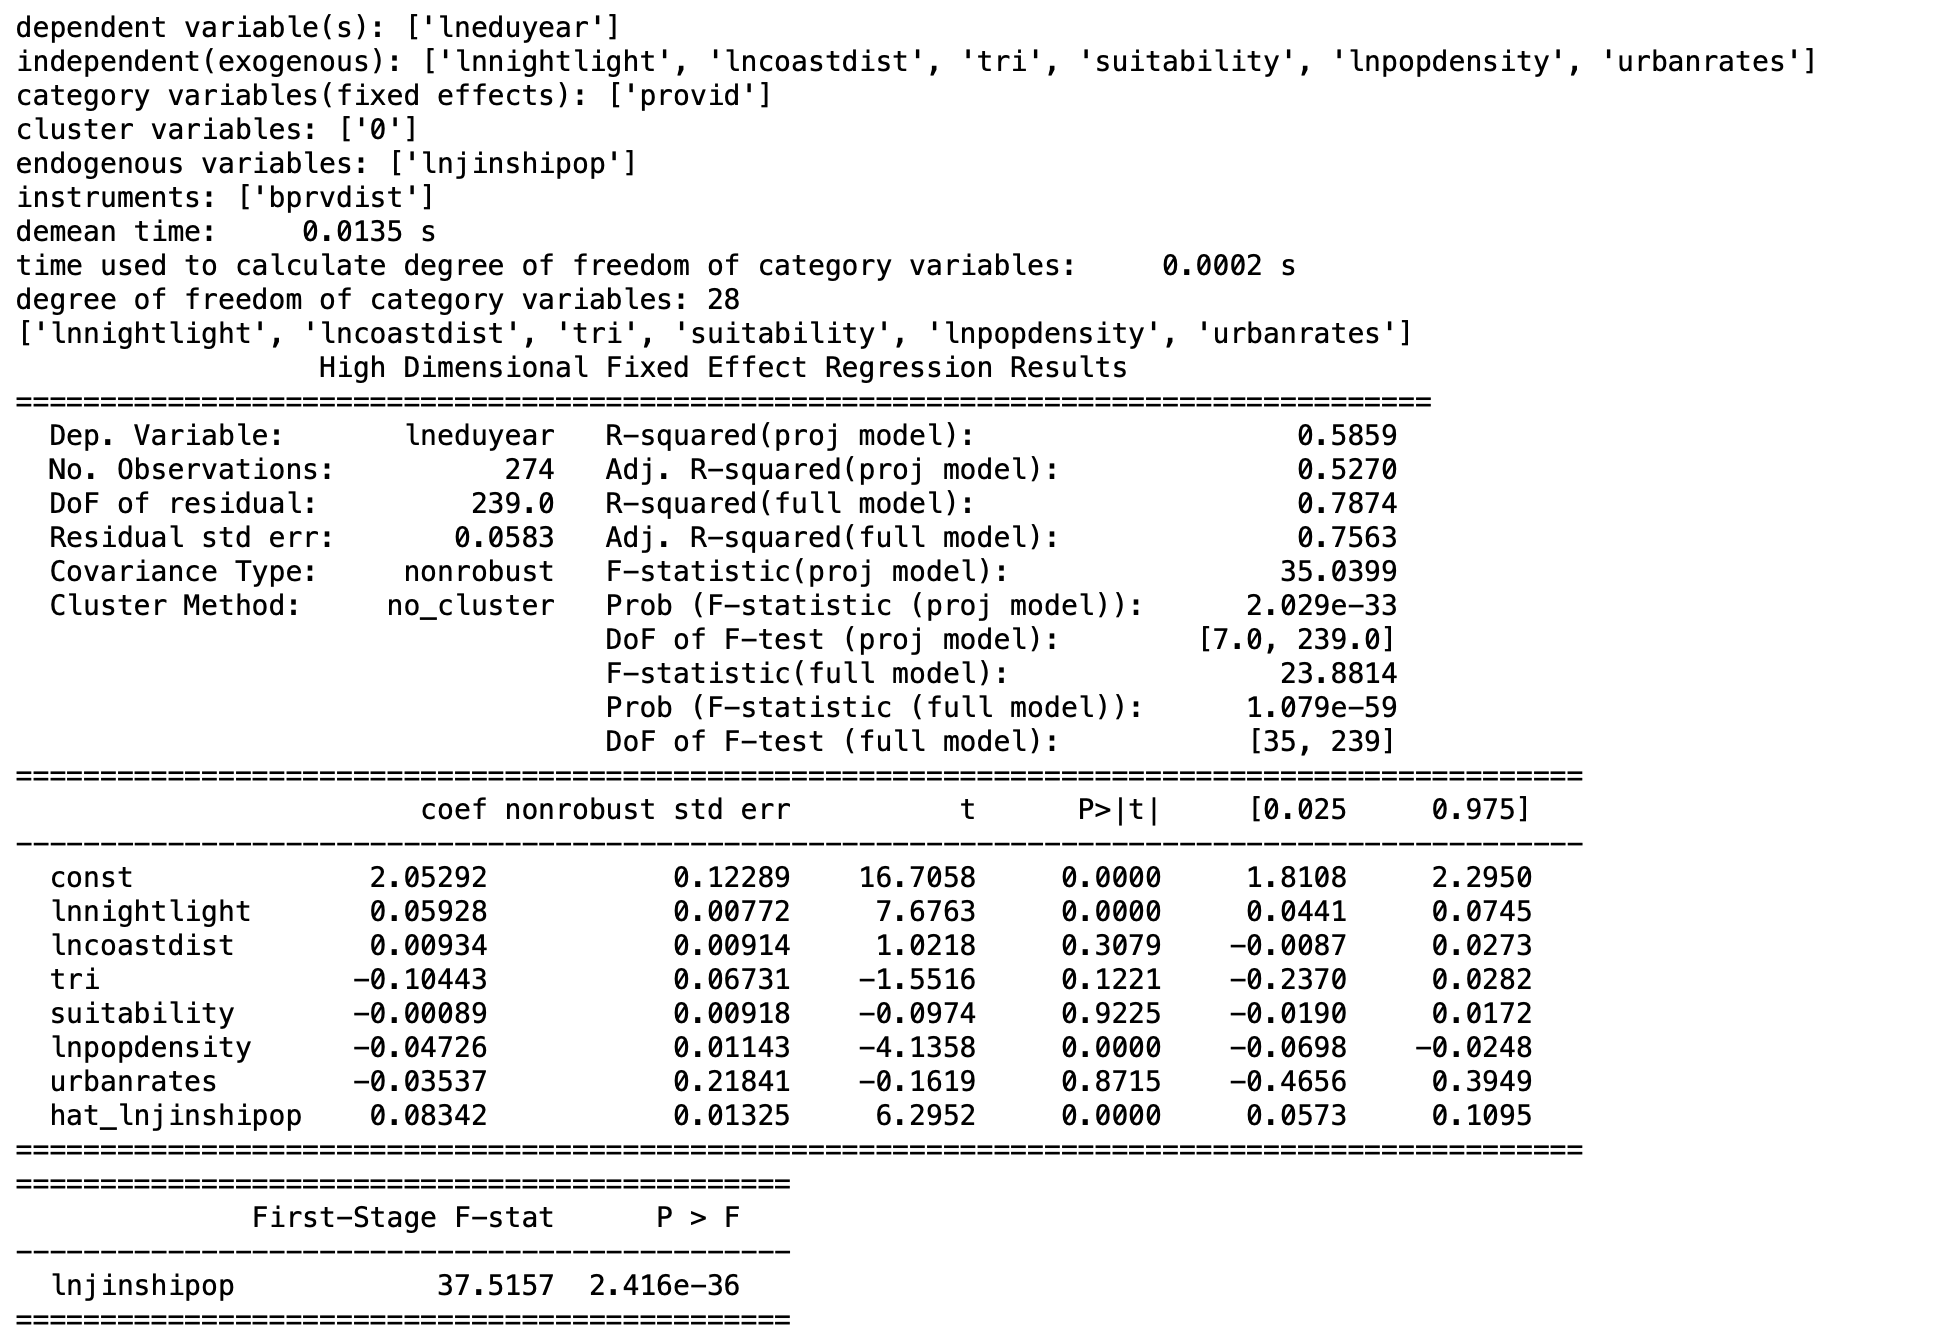

In [74]:
Image("/Users/mengxi/Documents/GitHub/ose-data-science-course-project-Mengxi-20/files/Table 10.png",width = 950)

Details of fixed effects can be checked in the following table.

In [75]:
# Table 11

#getfe(result_iv_fe_1)

# https://pypi.org/project/FixedEffectModel/

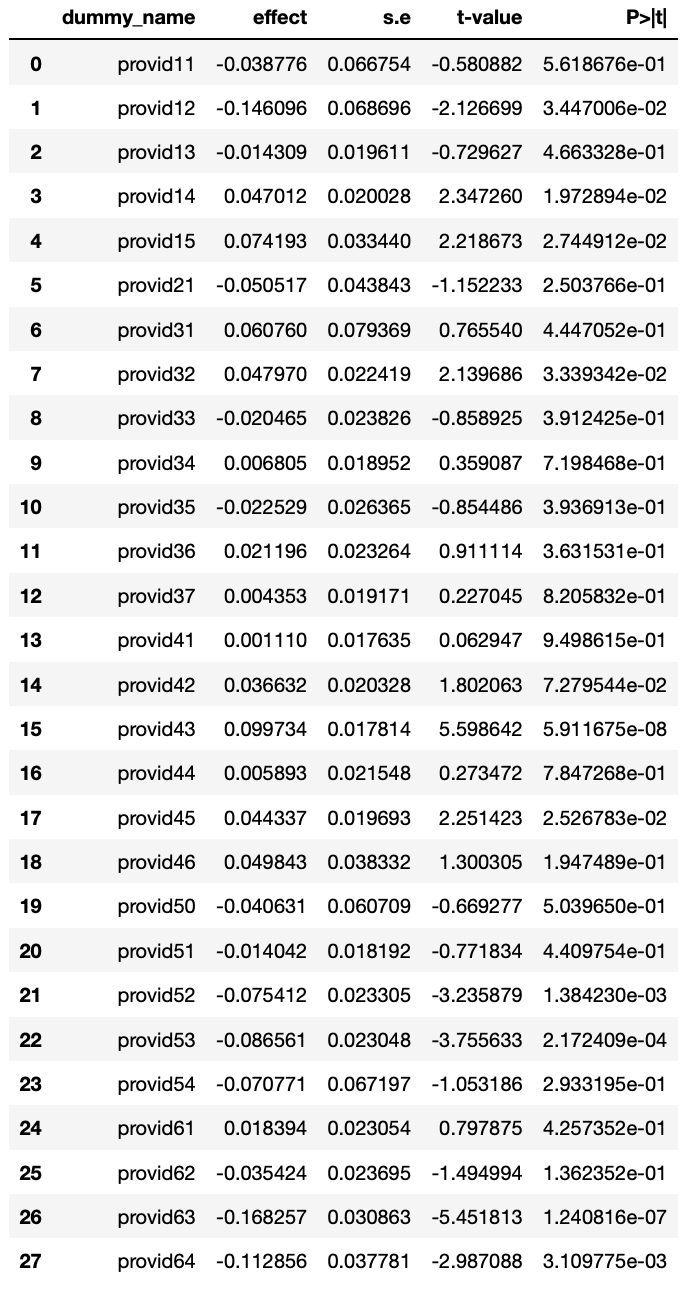

In [76]:
Image("/Users/mengxi/Documents/GitHub/ose-data-science-course-project-Mengxi-20/files/Table 11.png",width = 400)

---
# 5. Extension <a name="extension"></a>
---

## 5.1. Weak Instrument Test <a name="weak_ins"></a>

In instrumental variables regression, the instruments are called weak if their correlation with the endogenous regressors, conditional on any controls, is close to zero. When this correlation is sufficiently small, the TSLS results are generally unreliable. More detailed, if an instrument is considered weak, then the bias of the IV estimator can be larger and in some cases it can even be bigger than the bias of the OLS estimator. That is why a weak instrument test is necessary.

Cragg-Donald(1993) relies on an iid assumption on the errors. With one endogenous variable and one instrument the Cragg-Donald as a Wald statistic should be applicable and reliable. Here the null hypothesis is defined that the chosen instrumental variable is a week instrument. The maximum acceptable bias is set to 0.1, i.e. we tolerate a bias of 10% relative to OLS. In Table 12, it is clear that the critical value should be 8.96. If the first stage Cragg-Donald Wald F statistic is larger than this critical value, then the instrument is not considered weak. 

In Table 12 it is found that Cragg-Donald Statistics is 129.57, which is larger than the critical value at 10% level and even also larger than the critical value at 5% level. So the null hypothesis is rejected, i.e. the chosen instrument is not considered weak. The instrument is reasonably strong to replace the endogenous variable here and to filter the omitted variables.

In [77]:
# Table 12

#ivtest(result_iv_fe_1)

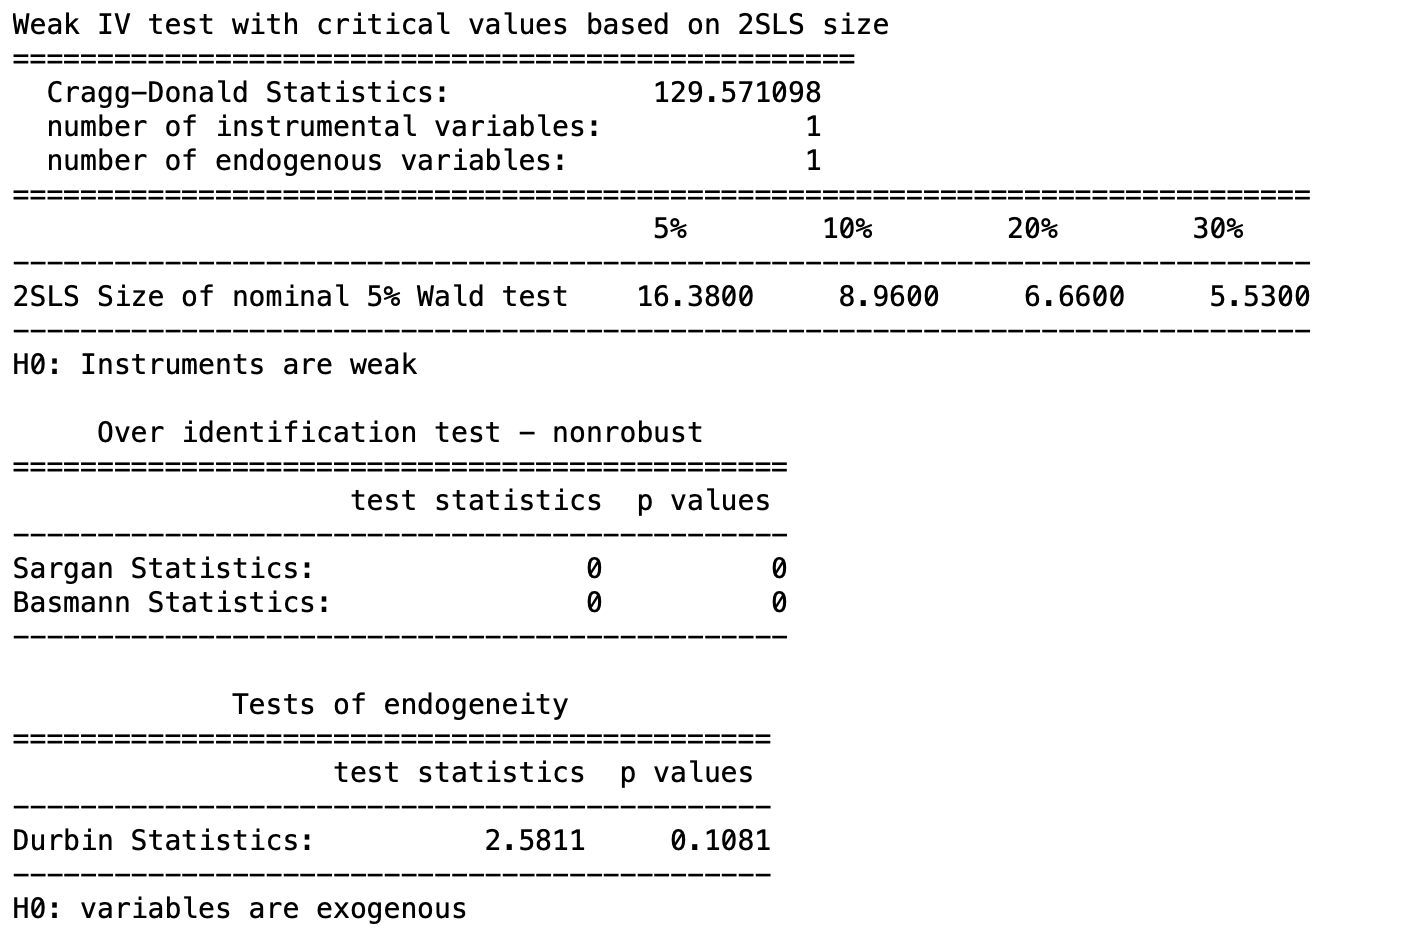

In [78]:
Image("/Users/mengxi/Documents/GitHub/ose-data-science-course-project-Mengxi-20/files/Table 12.png",width = 650)

## 5.2. The Persistent Effect of Keju Culture on Mainland China’s Current Population with Distinct Levels of Education <a name="Persistent_effect"></a> 
### 5.2.1. Inspiration and Assumption<a name="inspiration_assumption"></a>

In their paper, Chen et al. (2020) mentioned their assumption that since jinshi was the highest attainable qualification in imperial China's civil service examination (keju), it should have a greater impact on higher levels of current educational attainment. Chen et al. (2020) verified this by dividing Mainland China’s population in 2010 into four distinct levels of educational achievement: ‘no education’, ‘elementary and secondary school’, ‘high school’ and ‘university and above’. The examination results are as follows.


In [79]:
file_path = 'files/Abb_3.txt'
with open(file_path) as file_abb_3:
    data = file_abb_3.read()
print(data)

lnnspop         Share of population with no education (×100, logged)
lnmppop         Share of population with elementary and secondary school education (×100, logged)
lnhighpop       Share of population with high school education (×100, logged)
lnunipop        Share of population with university and above (×100, logged)


In [80]:
# Table 13

data = pd.read_csv('data/census20_final.csv')
data = pd.DataFrame(data)

provid = pd.Categorical(data.provid)

data['provid'] = provid
data = data.set_index(['provid','year'])

exog_vars = ['lnjinshipop','lnnightlight','lncoastdist','tri','suitability','lnpopdensity','urbanrates']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lnnspop,exog,entity_effects=True)
res1 = mod.fit(cov_type = 'clustered',cluster_effects=True)

exog_vars = ['lnjinshipop','lnnightlight','lncoastdist','tri','suitability','lnpopdensity','urbanrates']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lnmppop,exog,entity_effects=True)
res2 = mod.fit(cov_type = 'clustered',cluster_effects=True)

exog_vars = ['lnjinshipop','lnnightlight','lncoastdist','tri','suitability','lnpopdensity','urbanrates']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lnhighpop,exog,entity_effects=True)
res3 = mod.fit(cov_type = 'clustered',cluster_effects=True)

exog_vars = ['lnjinshipop','lnnightlight','lncoastdist','tri','suitability','lnpopdensity','urbanrates']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lnunipop,exog,entity_effects=True)
res4 = mod.fit(cov_type = 'clustered',cluster_effects=True)


print(compare({"(1)": res1, "(2)": res2, "(3)": res3, "(4)": res4}, stars = True, precision = "std_errors"))



                                  Model Comparison                                 
                                   (1)            (2)            (3)            (4)
-----------------------------------------------------------------------------------
Dep. Variable                  lnnspop        lnmppop      lnhighpop       lnunipop
Estimator                     PanelOLS       PanelOLS       PanelOLS       PanelOLS
No. Observations                   274            274            274            274
Cov. Est.                    Clustered      Clustered      Clustered      Clustered
R-squared                       0.4427         0.4802         0.4240         0.5389
R-Squared (Within)              0.0000         0.0000         0.0000         0.0000
R-Squared (Between)             0.6545         0.5018         0.6414         0.4289
R-Squared (Overall)             0.4384         0.2985         0.4411         0.3696
F-statistic                     27.123         31.544         25.131        

Table 13 confirms that jinshi density has a significantly negative effect on the share of population with educational attainment below high school, but a positive effect otherwise. As the coefficient increases, it is clear that keju culture has the strongest persistent effect on university education. Therefore, the assumption that jinshi density has a greater impact on higher levels of education is tenable.

This assumption holds when considering the population groups with a bachelor, master, or doctorate degree together as 'the population with university and above'. Chen et al. (2020) combined these three levels into one term. Although these levels’ sample is small for a highly-educated population, it still makes sense to determine whether the assumption still holds when considering the three population groups individually (**Extension 1**).

Chen et al. (2020)’s assumption was the source of my inspiration. As the keju’s highest degree, jinshi has a greater impact on current higher levels of education, which means that it has a greater impact on people who earned higher academic grades. As someone’s status as a graduate of a ‘Project 985 (a Chinese government funding initiative introduced on May 4, 1998) university' is used in Mainland China to assess their educational performance, jinshi density should have a greater impact on graduates of these universities in a Mainland Chinese context. **Extension 2** in this part verifies this assumption.

The concept of ‘university type’ is introduced to verify this assumption. As of May 2017, Mainland China has a total of 2,914 universities. However, only 39 of these universities are part of the ‘985 Project', which resembles Germany’s 'Exzellenzinitiative für deutschen Universitäten (German Universities Excellence Initiative)’. High school students and others who want to gain admission to any Mainland Chinese university must take the National College Entrance Examination (NCEE), also known as the [gaokao](https://en.wikipedia.org/wiki/Gaokao), which is a very challenging annual standardized college entrance examination. Although the gaokao and its historical predecessor (keju) are designed to select candidates for different purposes, they have similar structures and are equally challenging - keju culture's spirit still lives on today as the gaokao. In the overwhelming majority of cases, earning a higher score makes it possible to gain admission to a better university. Students who earn the absolute highest scores are often the only ones who can gain admission to a ‘Project 985 university’. Therefore, rather than dividing 'the population with university and above' into groups with a bachelor, master, or doctorate degree, it would be better to use the new definitions of 'the population with a Project 985 university education' and 'the population with an ordinary university education’.

It should be noted that the concept of a ‘Project 985 university' is neutral. Students who demonstrate better academic performance are more likely to gain admission to a 'Project 985 university' instead of students with better living conditions.

The context here is Mainland China, which is the same as in Chen et al. (2020). Chen et al. (2020)’s data excluded that of some provinces or regions, including Hong Kong, Macao and Taiwan.

### 5.2.2. Data Processing <a name="data_processing"></a>

The original data that Chen et. al. (2020) used for constructing variables comes from the 2010 population census. As verifying Extension 2 requires the details about 'university type', the data from the 2010 China Family Panel Studies (CFPS) of Peking University’s Institute of Social Science Survey (ISSS) is employed, and the 'university type' of those surveyed is included in the adult part of this survey.

Therefore, I downloaded the original CFPS data and selected the relevant data into a new database because the original one was too large to upload here.

The description of the selected data and its value's meaning can be verified as follows.



| question codes 	| question in the adult survey    	| value=-8    	| value=-1    	| value=0    	| value=1    	| 
|:-----------:	|:------	|:------:	|:------:	|:------:	|:------:	|
|    qc705    	| Do you have primary school graduation certificate? 	| not relevant 	| no idea 	| no 	| yes 	| 
|    qc605    	| Do you have middle school graduation certificate? 	| not relevant 	| / 	| no 	| yes 	| 
|    qc505    	| Do you have high school graduation certificate? 	| not relevant 	| / 	| no 	| yes 	| 
|    qc407    	| Do you have bachelor graduation certificate? 	| not relevant 	| / 	| no 	| yes 	| 
|    qc307    	| Do you have master graduation certificate? 	| not relevant 	| / 	| no 	| yes 	| 
|    qc307    	| Do you have doctor graduation certificate? 	| not relevant 	| / 	| no 	| yes 	| 


| value of college type 	| meaning    	| 
|:-----------:	|:------	|
|    1    	| '985 Project University' (top universities) 	| 
|    2    	| 'Ordinary University' (national key universities except top universities, 211 Project) 	| 
|    3    	| 'Ordinary University' (other key universities) 	| 
|    4    	| 'Ordinary University' (ordinaty universities) 	|
|    5    	| 'Ordinary University' (other universities) 	|

The following table illustrates the selected data.

In [81]:
# Table 14

data_org_selected = pd.read_csv('data/cfps2010_selected.csv')
data_org_selected = pd.DataFrame(data_org_selected)

# qc705 您是否获得了小学毕业证书 -8-不适用 -1-不知道 0-否 1-是
# qc605 您是否获得了初中毕业证书 -8-不适用 0-否 1-是
# qc505 您是否获得了高中毕业证书 -8-不适用 0-否 1-是
# qc407 您是否获得了大专毕业证书 -8-不适用 0-否 1-是
# qc307 您是否获得了学士学位 -8-不适用 0-否 1-是
# qc207 您是否获得了硕士学位 -8-不适用 0-否 1-是
# qc107 您是否获得了博士学位 -8-不适用 0-否 1-是
# collegetype  -8-不适用 1-全国重点院校(985高校，第一批次录取) 2-全国重点院校(非985的211院校，第一批次录取) 3-普通重点院校(第一批次录取)
# 4-普通本科院校(第二批次录取) 5-三本院校(第三批次录取) 
df = data_org_selected.dropna(axis=0, how='any', inplace=False)
df

,fid,provcd,collegetype,cfps2010eduy_best,qc705,qc605,qc505,qc407,qc307,qc207,qc107
1,110001,11,-8.0000,12,1,1,0,-8,-8,-8,-8
2,110003,11,-8.0000,12,1,1,1,-8,-8,-8,-8
3,110003,11,-8.0000,9,1,1,-8,-8,-8,-8,-8
4,110005,11,-8.0000,12,1,1,0,-8,-8,-8,-8
5,110005,11,-8.0000,12,1,1,1,-8,-8,-8,-8
...,...,...,...,...,...,...,...,...,...,...,...
33593,621870,62,-8.0000,0,-8,-8,-8,-8,-8,-8,-8
33594,621870,62,-8.0000,12,1,1,1,-8,-8,-8,-8
33595,621872,62,-8.0000,0,-8,-8,-8,-8,-8,-8,-8
33596,621872,62,-8.0000,11,1,1,-8,-8,-8,-8,-8


According to Chen et. al. (2020), the current method for selecting candidates constructed from the 2010 dataset, namely average years of schooling, was measured at the prefecture level and raised to the natural log. The share of population with different levels of education is calculated based on the following form: In (population with different levels of education / population × 100). The data processing method is shown below. Table 14 summarizes the processed data.



In [82]:
warnings.filterwarnings('ignore')

In [83]:
# process data
df = data_org_selected.dropna(axis=0, how='any', inplace=False)
#pd.options.display.float_format = '{:,.3f}'.format

# lneduyear 
group = df.groupby('provcd')
ln_eduyear = df.groupby('provcd').mean()['cfps2010eduy_best']
ln_eduyear = np.log(ln_eduyear)
ln_eduyear = ln_eduyear.to_frame('ln_eduyear')
ln_eduyear

group = df.groupby('provcd') 
def  generate_df_1(column,name,pop_type):
    
    temp_df = group[column].value_counts(normalize=True)
    temp_df = np.log(temp_df*100)
    temp_df = temp_df.to_frame(f'{name}').reset_index()
    temp_df = temp_df.loc[temp_df[column]==pop_type]
    return temp_df[['provcd',name]].set_index('provcd')

# lnnspop,select qc705=0
ln_nspop = generate_df_1(column = 'qc705',name = 'ln_nspop',pop_type = 0)
ln_nspop

# lnmppop, select qc605=1
ln_mppop = generate_df_1(column = 'qc605',name = 'ln_mppop',pop_type = 1)
ln_mppop

# lnhighpop, select qc505=1
ln_highpop = generate_df_1(column = 'qc505',name = 'ln_highpop',pop_type = 1)
ln_highpop

# lnbpop, select qc307=1
ln_bpop = generate_df_1(column = 'qc307',name = 'ln_bpop',pop_type = 1)
ln_bpop

# lnmpop, select qc207=1
ln_mpop = generate_df_1(column = 'qc207',name = 'ln_mpop',pop_type = 1)
ln_mpop

# lndpop, select qc107=1
ln_dpop = generate_df_1(column = 'qc107',name = 'ln_dpop',pop_type = 1)
ln_dpop

# ln_unipop, select qc307=1 or qc207=1 or qc107=1
columns = ['qc307','qc207','qc107']
for column in columns:
    df.loc[:,column] = df.loc[:,column].map(lambda x: 1 if x ==1 else  0 )

query_df = df.query('qc307==1|qc207==1|qc107==1')

df.loc[:,'degree_type'] = df.index.map(lambda x : 1 if x in query_df.index else 0)
group = df.groupby('provcd') 
ln_unipop = group['degree_type'].value_counts(normalize=True)
ln_unipop = np.log(ln_unipop*100)
ln_unipop = ln_unipop.to_frame('ln_unipop').reset_index()
ln_unipop = ln_unipop[ln_unipop['degree_type']==1][['provcd','ln_unipop']].set_index('provcd')

# ln_985pop, select collegetype=1
group = df.groupby('provcd')
ln_985pop = group['collegetype'].value_counts(normalize=True)
ln_985pop = np.log(ln_985pop*100)  
ln_985pop = ln_985pop.to_frame('ln_985pop').reset_index()
ln_985pop = ln_985pop.loc[ln_985pop['collegetype']==1][['provcd','ln_985pop']].set_index('provcd')

# ln_oupop, select collegetype=2/3/4/5

query_df = df.query('collegetype==2|collegetype==3|collegetype==4|collegetype==5')
df.loc[:,'uni_type'] = df.index.map(lambda x : 1 if x in query_df.index else 0)
group = df.groupby('provcd') 
ln_oupop = group['uni_type'].value_counts(normalize=True)
ln_oupop = np.log(ln_oupop*100)
ln_oupop = ln_oupop.to_frame('ln_oupop').reset_index()
ln_oupop = ln_oupop[ln_oupop['uni_type']==1][['provcd','ln_oupop']].set_index('provcd')



In [84]:
# ln_jinshipop
data = pd.read_csv('data/census20_final.csv')
data = pd.DataFrame(data)
group = data.groupby('provid')
ln_jinshipop = data.groupby('provid').mean()['lnjinshipop']
ln_jinshipop = ln_jinshipop.to_frame('ln_jinshipop')

# ln_nightlight
ln_nightlight = data.groupby('provid').mean()['lnnightlight']
ln_nightlight = ln_nightlight.to_frame('ln_nightlight')

# ln_coastdist
ln_coastdist = data.groupby('provid').mean()['lncoastdist']
ln_coastdist = ln_coastdist.to_frame('ln_coastdist')

# tri_
tri_ = data.groupby('provid').mean()['tri']
tri_ = tri_.to_frame('tri_')

# suitability_
suitability_ = data.groupby('provid').mean()['suitability']
suitability_ = suitability_.to_frame('suitability_')

# ln_popdensity
ln_popdensity = data.groupby('provid').mean()['lnpopdensity']
ln_popdensity = ln_popdensity.to_frame('ln_popdensity')

# urbanrates_
urbanrates_ = data.groupby('provid').mean()['urbanrates']
urbanrates_ = urbanrates_.to_frame('urbanrates_')



In [85]:
# Table 14 Data summary
pd.options.display.float_format = '{:,.4f}'.format
df_processed = pd.concat([ln_jinshipop, ln_eduyear,ln_nspop,ln_mppop,ln_highpop,ln_bpop,ln_mpop,ln_dpop,ln_unipop, ln_oupop, ln_985pop, ln_nightlight, ln_coastdist, tri_, suitability_, ln_popdensity, urbanrates_],axis=1).fillna(0)
df_processed.head(4)

,ln_jinshipop,ln_eduyear,ln_nspop,ln_mppop,ln_highpop,ln_bpop,ln_mpop,ln_dpop,ln_unipop,ln_oupop,ln_985pop,ln_nightlight,ln_coastdist,tri_,suitability_,ln_popdensity,urbanrates_
11,3.5248,2.3995,2.5387,4.3532,3.9421,2.0618,0.7809,0.0000,2.0618,1.3687,1.8105,2.7581,11.9172,0.1139,2.4657,2.2687,0.0344
12,3.7154,2.1025,2.1335,4.1378,3.4086,0.7985,0.0000,0.0000,0.7985,1.2685,-0.8109,2.7053,11.3174,0.0537,2.3115,2.8506,0.0158
13,1.0195,2.0033,3.2411,3.8299,2.7872,-0.0215,-2.1616,0.0000,-0.0215,0.4034,-1.2453,1.7088,11.9519,0.0970,2.3316,2.4113,0.0484
14,0.8903,2.0103,3.1717,3.8140,2.8669,-0.1849,-2.0567,0.0000,-0.1849,0.3412,-1.6512,1.2866,13.0878,0.2942,2.9646,1.9766,0.0560


### 5.2.3. Examination and Results <a name="reg2"></a>

**Extension 1**

To zoom in on the distinct levels of academic degrees above high school, we verified the ordinary least squares (OLS) result in Table 15. As a different dataset from that used by Chen et al. (2020) is considered here, the OLS result for levels of education under university is re-calculated in Table 15.

It has been shown that jinshi density has a negative effect on the share of population with no education (column(1)), but a positive effect on that with education ranging from primary school to a master degree (column(2) to column(5)). The latter’s much larger coefficient suggests that keju culture’s persistent effect is stronger on higher levels of education from primary school to a bachelor degree, which corresponds to Chen et al. (2020)'s assumption. However, this assumption does not hold for master and doctorate degrees (column(5) and column(6)). The reason should be the overly small sampling of those surveyed with these levels of education. It was also observed that the OLS results for the share of population with these degrees are not significant. Therefore, the decision that Chen et al (2020) made - considering the population with bachelor, master and doctorate degrees together as 'the population with university and above' - is very reasonable and cogent.


In [86]:
# Table 15

result1 = smf.ols('ln_nspop ~ ln_jinshipop + ln_nightlight + ln_coastdist + tri_ + suitability_ + ln_popdensity + urbanrates_', data = df_processed).fit()
result2 = smf.ols('ln_mppop ~ ln_jinshipop + ln_nightlight + ln_coastdist + tri_ + suitability_ + ln_popdensity + urbanrates_', data = df_processed).fit()
result3 = smf.ols('ln_highpop ~ ln_jinshipop + ln_nightlight + ln_coastdist + tri_ + suitability_ + ln_popdensity + urbanrates_', data = df_processed).fit()
result4 = smf.ols('ln_bpop ~ ln_jinshipop + ln_nightlight + ln_coastdist + tri_ + suitability_ + ln_popdensity + urbanrates_', data = df_processed).fit()
result5 = smf.ols('ln_mpop ~ ln_jinshipop + ln_nightlight + ln_coastdist + tri_ + suitability_ + ln_popdensity + urbanrates_', data = df_processed).fit()
result6 = smf.ols('ln_dpop ~ ln_jinshipop + ln_nightlight + ln_coastdist + tri_ + suitability_ + ln_popdensity + urbanrates_', data = df_processed).fit()


sum = summary_col([result1, result2, result3, result4, result5, result6], stars = True)
print(sum)



                ln_nspop  ln_mppop  ln_highpop ln_bpop  ln_mpop   ln_dpop  
---------------------------------------------------------------------------
Intercept      2.8384*** 3.7157***  2.8927***  0.3196   -0.9050  0.0695    
               (0.7133)  (0.7294)   (0.5868)   (0.4568) (0.8264) (0.3343)  
ln_jinshipop   -0.1766   0.2781     0.3791     0.5381** 0.4962   -0.0120   
               (0.3040)  (0.3108)   (0.2501)   (0.1946) (0.3522) (0.1425)  
ln_nightlight  0.3852    0.3041     0.2041     0.0996   -0.2792  0.1644    
               (0.2695)  (0.2756)   (0.2217)   (0.1726) (0.3122) (0.1263)  
ln_coastdist   -0.2185*  -0.4210*** -0.3133*** -0.0348  -0.0382  -0.0072   
               (0.1116)  (0.1141)   (0.0918)   (0.0715) (0.1293) (0.0523)  
tri_           0.9003    0.5975     -0.0977    0.0690   -0.0142  -0.1728   
               (2.0961)  (2.1435)   (1.7244)   (1.3423) (2.4284) (0.9825)  
suitability_   0.6479    1.5530***  1.1051**   -0.0466  0.0665   0.2461    
           

**Extension 2**

Table 16 is used to verify whether jinshi density has different impacts on current methods of selecting candidates depending on 'university type’, and it focuses on the coefficient of ln_oupop (share of population with 'ordinary university' education (×100, logged)) and ln_985pop (share of population with '985 Project University' education (×100, logged)).

It was observed that keju culture has a positive and larger impact on a population with a ‘Project 985 university’ education as compared with one with an 'ordinary university' education. This result for the former is significant at a 1% level, while that for the latter is significant at a 10% level, which is not ‘statistically significant’. Therefore, the null hypothesis cannot be retained.

If the sample size could be extended with a more recent dataset, the significance level of the result for the population with a ‘Project 985 university' education could be improved, as Mainland Chinese university enrollment and the CFPS survey scope have expanded since 2010.

In [87]:
# Table 16

result1 = smf.ols('ln_nspop ~ ln_jinshipop + ln_nightlight + ln_coastdist + tri_ + suitability_ + ln_popdensity + urbanrates_', data = df_processed).fit()
result2 = smf.ols('ln_mppop ~ ln_jinshipop + ln_nightlight + ln_coastdist + tri_ + suitability_ + ln_popdensity + urbanrates_', data = df_processed).fit()
result3 = smf.ols('ln_highpop ~ ln_jinshipop + ln_nightlight + ln_coastdist + tri_ + suitability_ + ln_popdensity + urbanrates_', data = df_processed).fit()
result4 = smf.ols('ln_oupop ~ ln_jinshipop + ln_nightlight + ln_coastdist + tri_ + suitability_ + ln_popdensity + urbanrates_', data = df_processed).fit()
result5 = smf.ols('ln_985pop ~ ln_jinshipop + ln_nightlight + ln_coastdist + tri_ + suitability_ + ln_popdensity + urbanrates_', data = df_processed).fit()

sum = summary_col([result1, result2, result3, result4, result5], stars = True)
print(sum)


                ln_nspop  ln_mppop  ln_highpop  ln_oupop ln_985pop
------------------------------------------------------------------
Intercept      2.8384*** 3.7157***  2.8927***  0.4482    -0.9987  
               (0.7133)  (0.7294)   (0.5868)   (0.3464)  (0.6484) 
ln_jinshipop   -0.1766   0.2781     0.3791     0.5060*** 0.5519*  
               (0.3040)  (0.3108)   (0.2501)   (0.1476)  (0.2763) 
ln_nightlight  0.3852    0.3041     0.2041     0.0163    -0.2616  
               (0.2695)  (0.2756)   (0.2217)   (0.1309)  (0.2450) 
ln_coastdist   -0.2185*  -0.4210*** -0.3133*** -0.0110   0.1531   
               (0.1116)  (0.1141)   (0.0918)   (0.0542)  (0.1015) 
tri_           0.9003    0.5975     -0.0977    -0.7579   -2.8263  
               (2.0961)  (2.1435)   (1.7244)   (1.0178)  (1.9054) 
suitability_   0.6479    1.5530***  1.1051**   -0.0976   -0.4969  
               (0.4913)  (0.5024)   (0.4042)   (0.2386)  (0.4466) 
ln_popdensity  0.0733    0.0256     -0.0311    -0.2520   -0.2

---
# 6. Conclusion
---

This notebook successfully replicates Chen et al. (2020)’s main results. A causal relationship between the keju and current methods of selecting candidates has been verified. The main results were precisely reproduced in Section 4. The replication of identifying possible channels of keju persistence was not included because it was calculated using another sample of original data. The regressions were accurately described, and Stata code was available for some of the tables. 

Problems occurred when fixed effects were added to the IV regressions. These regressions were not easy to run in Python because the appropriate module for two-stage least squares estimation (function IV2SLS) does not provide a chance to process panel data, and the module for panel data models (function PanelOLS) cannot process instrumental variables. An extensive amount of time was spent on this aspect because many methods were tried, which even included switching the programming language from Python to R.

In addition, the notebook contains a test of weak instruments and an examination of keju's impacts on populations with distinct levels of educational achievement in 2010 as an extension of Chen et al. (2020)’s findings. The main issue when examining the persistent effect of keju culture was transforming raw data into meaningful output. Although it was ultimately not possible to retain the null hypothesis, it still has a chance of not getting rejected.

Overall, Chen et al. (2020) offered an ingenious design and an interesting application of instrumental variables. This observation of a strong, positive relationship between prefectures with a strong historical tradition of exam success and current years of schooling enabled Chen et al. (2020) to contribute important insights to the persistent impact of a remarkably long-lived institution — imperial China’s civil service examination system — methods of selecting candidates or current educational attainment. Moreover, Chen et al. (2020) further demonstrated that this relationship is causal by using the average river distance to a prefecture’s nearest pine and bamboo forests as an instrument, which produced the main tools for printing.


---
# 7. Reference <a name="references"></a>
---

* **Chen, T., Kung, J. K. S., & Ma, C. (2020)**. Long Live Keju! The Persistent Effects of China’s Civil Examination System. *The Economic Journal*, 130(631), 2030–2064. https://doi.org/10.1093/ej/ueaa043

* **Jeffrey M Wooldridge**. Econometric analysis of cross section and panel data. MIT press, 2010.

* **Jing, X., & Liu, L. (2019)**. The Equity of Gaokao (National University/College Entrance Examination) in China. *Review of Educational Theory*, 2(3), 29. https://doi.org/10.30564/ret.v2i3.881

* **Kuaishou DA Ecology**. FixedEffectModel: A Python Package for Linear Model with High Dimensional Fixed Effects.https://github.com/ksecology/FixedEffectModel,2020.Version 0.x

* **Semykina & Wooldridge (2010)**. Estimating panel data models in the presence of endogeneity and selection. *Journal of Econometrics*, 157(2): pp. 375-380. https://doi.org/10.1016/j.jeconom.2010.03.039
